In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 10.6 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 596 kB 39.6 MB/s 
     |████████████████████████████████| 6.6 MB 56.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import torch
import transformers
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

from scipy.optimize import minimize, Bounds

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment-rusentiment')
# 0 - нейтральное, 1 - позитивное, 2 - негативное
rubert = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment-rusentiment', return_dict=True)
rubert.eval()

@torch.no_grad()
def bert_predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    outputs = rubert(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    # predicted = torch.argmax(predicted, dim=1).numpy()
    return predicted

Downloading:   0%|          | 0.00/495 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/679M [00:00<?, ?B/s]

In [ ]:
bert_predict('Это место очень хорошее'), bert_predict('Ты очень грубый'), bert_predict('Мне без разницы')

(tensor([[0.0030, 0.9957, 0.0013]]),
 tensor([[0.2490, 0.0026, 0.7484]]),
 tensor([[0.9873, 0.0055, 0.0072]]))

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2022/sber_app.csv', index_col=0)
df.head()

,title,userName,rating,review,date,isEdited,developerResponse
0,Отличное приложение,Anechkina_smile,5,Я очень довольна. Даже не могу придумать минус...,2017-04-25 06:53:10,False,NaN
1,Верните как было,Li$$,1,Хватит забивать приложение и нагружать его вся...,2019-01-12 07:52:02,False,NaN
2,Дно,Dykis,1,"Вы настолько мразотный банк, что даже нигде не...",2020-05-31 16:32:19,False,"{'id': 15686705, 'body': 'Мы рассказали об это..."
3,Фууууу,пренорвв,1,Че за бред комиссия за перевод внутри банка в ...,2019-08-27 15:39:14,False,NaN
4,Разгрузите приложение,Eduardazizov,1,"Уберите все те сомнительные функции, которые д...",2018-10-27 17:27:52,False,NaN


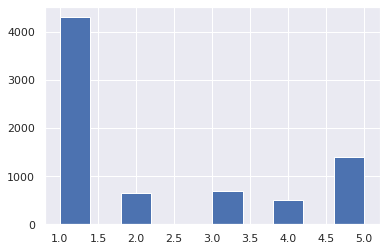

In [5]:
df['rating'].hist()

In [6]:
df['rating'].value_counts(normalize=True)

1    0.570822
5    0.184748
3    0.090849
2    0.086074
4    0.067507
Name: rating, dtype: float64

In [7]:
df['review'].isna().sum().sum()

0

In [8]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns].values

In [9]:
class AddTargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, ):
        pass
    
    def encode_rating(self, rating): 
        return np.where(rating <= 2, 1, 0)  # 1 - негативный, 0 - (позитивный или нейтральный)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.encode_rating(X.flatten())

### Baseline: PreTrained RuBert

In [10]:
class PreTrainBertProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X должен быть размера (*, 1)
        bert_brobs = []
        for string in tqdm(X):
            # string - список из одного элемента
            probs = bert_predict(string[0])[0]  # (1, 3) -> 3
            bert_brobs.append(probs.numpy())
        return np.array(bert_brobs)

##### Получаем иксы и игреки

In [11]:
df[set(df.columns) - set(['rating'])]

,review,developerResponse,isEdited,title,date,userName
0,Я очень довольна. Даже не могу придумать минус...,NaN,False,Отличное приложение,2017-04-25 06:53:10,Anechkina_smile
1,Хватит забивать приложение и нагружать его вся...,NaN,False,Верните как было,2019-01-12 07:52:02,Li$$
2,"Вы настолько мразотный банк, что даже нигде не...","{'id': 15686705, 'body': 'Мы рассказали об это...",False,Дно,2020-05-31 16:32:19,Dykis
3,Че за бред комиссия за перевод внутри банка в ...,NaN,False,Фууууу,2019-08-27 15:39:14,пренорвв
4,"Уберите все те сомнительные функции, которые д...",NaN,False,Разгрузите приложение,2018-10-27 17:27:52,Eduardazizov
...,...,...,...,...,...,...
7535,"Мне,как пожилому человеку пользоваться удобно....","{'id': 25995827, 'body': 'Здравствуйте! Рады, ...",False,…,2021-10-29 09:07:40,ломаковка
7536,Верните функцию для сохранения чека в фото!😡,"{'id': 25448317, 'body': 'Здравствуйте! Провер...",True,Сохранить чек в фото,2021-10-29 09:27:01,Julia-sagirova
7537,"Перегруженное кучей всего ненужного, тяжелое и...","{'id': 25995281, 'body': 'Здравствуйте! Мы пре...",False,"Начали за здравие, кончили….",2021-10-29 09:17:49,Lekos
7538,В программе могу посмотреть и найти нужный бан...,"{'id': 24108587, 'body': 'Спасибо за предложен...",True,Нерабочие банкоматы.,2021-10-29 08:51:54,HelpAbout


In [12]:
pipeline_target = Pipeline([
    ('selector', DataFrameSelector(columns=['rating'])),
    ('encoding', AddTargetEncoding()),
])

df_train, df_test, Y_train, Y_test = train_test_split(
    df[set(df.columns) - set(['rating'])],  # X - без rating
    pipeline_target.fit_transform(df),  # Y - в виде {1 - негативное, 0 - позитивное, или нейтральное}
    test_size=0.25, random_state=42, shuffle=True,
    stratify=df['rating'].values  # стратификация по rating в цифрах, а не в бинарном векторе негативных отзывов. Из первой вытекает вторая
)

In [ ]:
df_train.shape, Y_train.shape

((5655, 6), (5655,))

In [ ]:
df_test.shape, Y_test.shape

((1885, 6), (1885,))

In [ ]:
pipeline_bert_review = Pipeline([
    ('selector', DataFrameSelector(columns=['review'])),
    ('bert', PreTrainBertProcessing())
])

# в 1-ой версии прогноз берется только анализируя df['review']
X_train = pipeline_bert_review.fit_transform(df_train)
X_test = pipeline_bert_review.transform(df_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5655 [00:00<?, ?it/s]

  0%|          | 0/1885 [00:00<?, ?it/s]

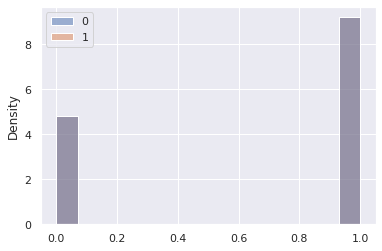

In [ ]:
sns.histplot(data=[Y_train, Y_test], stat='density', common_norm=False,)

In [ ]:
# в X_test уже лежат прогнозы руберта
test_baseline_preds = [int(np.argmax(pred, axis=0) == 2) for pred in X_test]  # индекс максимальной вер-ти соответствует положению негативного отзыва

In [22]:
def get_metrics(gt, predicted):
    rec, prec = recall_score(gt, predicted), precision_score(gt, predicted)
    f1 = f1_score(gt, predicted)
    roc_auc = roc_auc_score(gt, predicted)

    metric_names = ['recall', 'precision', 'f1', 'roc auc']
    metric_values = [rec, prec, f1, roc_auc]

    return dict(zip(metric_names, metric_values))

In [ ]:
get_metrics(gt=Y_test, predicted=test_baseline_preds)

{'f1': 0.6736541210100048,
 'precision': 0.8211382113821138,
 'recall': 0.5710823909531503,
 'roc auc': 0.6665303763111965}

Улучшаем baseline

Предсказываемся (не учимся!!!) на X_train, используя столбцы review и title, а потом находим для линейной комбинации с ними коэффициенты. И считаемся на тесте 

In [ ]:
# X_train хранит трэин фичи берта для review
# X_test хранит тестовые фичи берта для review

In [ ]:
pipeline_bert_title = Pipeline([
    ('selector', DataFrameSelector(columns=['title'])),
    ('bert', PreTrainBertProcessing())
])

pipeline_bert_all = FeatureUnion(transformer_list=[
    ('review', pipeline_bert_review),
    ('title', pipeline_bert_title)
])

X_train_with_title = np.hstack([X_train, pipeline_bert_title.fit_transform(df_train)])  # можно использовать pipeline_bert_all, но pipeline_bert_review будет считаться заново, а это долго
X_test_with_title = np.hstack([X_test, pipeline_bert_title.transform(df_test)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5655 [00:00<?, ?it/s]

  0%|          | 0/1885 [00:00<?, ?it/s]

In [ ]:
def fun(x0, preds, gts):
    bert_probs, bert_probs_title = preds
    linear_comb = x0[0] * bert_probs + x0[1] * bert_probs_title  # (X_train.shape[0], 3)
    indices = np.argmax(linear_comb, axis=1)  # 0, 1, 2
    negarive_instances = indices == 2
    return -f1_score(gts, negarive_instances)

predictions = (
    np.array(X_train_with_title[:, :3]),  # первые три - review
    np.array(X_train_with_title[:, 3:]),  # title
)

point = minimize(
    fun=fun,
    x0=(0.5, 0.5),
    args=(predictions, Y_train),
    method='Nelder-Mead',
    tol=1e-12,
    options={'maxiter': 1000}
)
point.x

array([ 4.96713648, -4.78839149])

In [ ]:
-fun(x0=point.x, preds=(np.array(X_test_with_title[:, :3]), np.array(X_test_with_title[:, 3:])), gts=Y_test)

0.7234739860712822

=> улучшили

#### Можно попробовать алгоритмы

In [ ]:
model = LogisticRegression(max_iter=10000, solver='liblinear', random_state=42, n_jobs=-1, )

pipeline = Pipeline([
    # правильно сделать так, но 20000 fits, т.е. ждать пока 20к раз прогонится берт на фолдах множества,
    # при этом результат будет одинаков (так как transform и fit_transorm одинаковы)
    # ('feats', pipeline_bert_all),
    ('estimator', model),
])

parameters = {
    'estimator__C': np.logspace(-2, 2, 1000),
    'estimator__penalty': ['l1', 'l2'],
    'estimator__class_weight': [None, 'balanced'],
}

scoring = {
    'f1': 'f1',
}

gs = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=scoring, n_jobs=-1, refit='f1', cv=5, verbose=3)

# gs.fit(df_train, Y_train)

# так можно делать, так как получение фичей не зависит от множества (transform и fit_transform одинаковы),
# т.е. результат по метрике одинаков и утечки данных нет, при этом в сотни раз быстрее
gs.fit(X_train_with_title, Y_train)  

print(gs.best_params_)
gs.best_score_

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits
{'estimator__C': 0.03254711605531848, 'estimator__class_weight': None, 'estimator__penalty': 'l2'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


0.8324215467916554

In [ ]:
get_metrics(Y_test, gs.predict(X_test_with_title))

{'f1': 0.8250084947332654,
 'precision': 0.7120234604105572,
 'recall': 0.9806138933764136,
 'roc auc': 0.6108633609076812}

In [ ]:
np.logspace(-2, 1, 20)[0]

0.01

In [ ]:
model = SVC(random_state=42, probability=True)

pipeline = Pipeline([
    ('estimator', model),
])

parameters = {
    'estimator__C': np.logspace(-2, 2, 20),
    'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'estimator__class_weight': [None, 'balanced'],
    'estimator__gamma': ['scale', 'auto']
}

scoring = {
    'f1': 'f1',
}

gs_svc = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=scoring, n_jobs=-1, refit='f1', cv=5, verbose=3)
gs_svc.fit(X_train_with_title, Y_train)

print(gs_svc.best_params_)
gs_svc.best_score_

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
{'estimator__C': 2.06913808111479, 'estimator__class_weight': None, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}


0.831875015722584

In [ ]:
get_metrics(Y_test, gs_svc.predict(X_test_with_title))

{'f1': 0.8250423011844332,
 'precision': 0.7099592312172394,
 'recall': 0.9846526655896607,
 'roc auc': 0.6074731643249695}

In [ ]:
model = GaussianNB()

pipeline = Pipeline([
    ('estimator', model),
])

parameters = {
    'estimator__var_smoothing': [1e-9],
}

scoring = {
    'f1': 'f1',
}

gs_naive = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=scoring, n_jobs=-1, refit='f1', cv=5, verbose=3)

gs_naive.fit(X_train_with_title, Y_train)

print(gs_naive.best_params_)
gs_naive.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'estimator__var_smoothing': 1e-09}


0.8245989321847773

In [ ]:
get_metrics(Y_test, gs_naive.predict(X_test_with_title))

{'f1': 0.818924438393465,
 'precision': 0.7076470588235294,
 'recall': 0.9717285945072698,
 'roc auc': 0.6017839263108219}

In [ ]:
model = KNeighborsClassifier(n_jobs=-1,)

pipeline = Pipeline([
    ('estimator', model),
])

parameters = {
    'estimator__n_neighbors': list(range(3, 200 + 1)),
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2],
    # 'estimator__leaf_size': list(range(10, 30 + 1, 1))
}

scoring = {
    'f1': 'f1',
}

gs_knn = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=scoring, n_jobs=-1, refit='f1', cv=5, verbose=3)
gs_knn.fit(X_train_with_title, Y_train)

print(gs_knn.best_params_)
gs_knn.best_score_

Fitting 5 folds for each of 792 candidates, totalling 3960 fits
{'estimator__n_neighbors': 133, 'estimator__p': 2, 'estimator__weights': 'uniform'}


0.8298747185274957

In [ ]:
get_metrics(Y_test, gs_knn.predict(X_test_with_title))

{'f1': 0.8263473053892216,
 'precision': 0.7326670830730794,
 'recall': 0.9474959612277868,
 'roc auc': 0.6429906390373865}

In [ ]:
# estimators = [
#     ('naive', gs_naive),
#     ('svc', gs_svc),
#     ('logistic', gs)
# ]

# voting = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
# voting.fit(X_train_with_title, Y_train)
# get_metrics(Y_test, voting.predict(X_test_with_title))

In [ ]:
def fun(x0, preds, gts):
    linear_comb = 0
    for i, array_preds in enumerate(preds):
        linear_comb += x0[i] * array_preds

    indices = np.argmax(linear_comb, axis=1)  # 0, 1 (негатив)
    # negarive_instances = indices == 2
    return -f1_score(gts, indices)

predictions = (
    gs_naive.predict_proba(X_train_with_title),
    gs_svc.predict_proba(X_train_with_title),
    gs.predict_proba(X_train_with_title),
    gs_knn.predict_proba(X_train_with_title),
)

point = minimize(
    fun=fun,
    x0=(
        0.2,
        0.3,
        0.3,
        0.2
    ),
    args=(predictions, Y_train),
    method='Nelder-Mead',
    tol=1e-15,
    options={'maxiter': 10000}
)
point.x

array([0.195   , 0.305625, 0.305625, 0.20375 ])

In [ ]:
-fun(
    x0=point.x,
    preds=(
        gs_naive.predict_proba(X_test_with_title),
        gs_svc.predict_proba(X_test_with_title),
        gs.predict_proba(X_test_with_title),
        gs_knn.predict_proba(X_test_with_title),
    ),
    gts=Y_test,
)

0.8239292997960572

Ансамблем улучшить не получилось

In [ ]:
df_train.head()

,title,date,review,isEdited,userName,developerResponse
1780,Проблема сбп,2021-06-01 08:49:10,"Выбивает ошибку, невозможно перевести средства...",False,Knizhechka,"{'id': 23179903, 'body': 'Здравствуйте! Попроб..."
2093,Оптимизация ни какая для iPad pro 2020,2021-03-22 05:00:43,"Сделайте оптимизацию для планшетов, такой позо...",False,IvanRRRRR,"{'id': 21840644, 'body': 'Здравствуйте! К сожа..."
7138,Сбербанк онлайн,2021-11-16 19:24:43,По воле судьбы приходится много ездить по миру...,False,kamoha70,"{'id': 26374883, 'body': 'Добрый день! Благода..."
4135,История операций Сбербанк онлайн,2018-07-15 06:43:28,После обновления в разделе истоия операций > с...,False,Ghhjkldftr123,"{'id': 4252525, 'body': 'Мы хотим разобраться ..."
7427,Отличное приложение,2021-11-03 07:40:10,"Все интуитивно понятно и просто, без него как ...",False,дмитрий да,"{'id': 26119659, 'body': 'Здравствуйте!\nБлаго..."


In [ ]:
df_train['isEdited'].value_counts(normalize=True)  # низкодиспресионный

False    0.958798
True     0.041202
Name: isEdited, dtype: float64

In [ ]:
df_train['userName'].nunique(), df_train.shape

(5655, (5655, 6))

In [ ]:
df_train.date.min(), df_train.date.max()

('2017-04-25 04:40:31', '2022-04-06 15:15:12')

In [ ]:
# ответ на отзыв и уникальное имя пользователя
df_train.drop(['developerResponse', 'userName', 'isEdited'], axis=1, inplace=True)
df_test.drop(['developerResponse', 'userName', 'isEdited'], axis=1, inplace=True)

In [ ]:
df_train.head()

,title,date,review
1780,Проблема сбп,2021-06-01 08:49:10,"Выбивает ошибку, невозможно перевести средства..."
2093,Оптимизация ни какая для iPad pro 2020,2021-03-22 05:00:43,"Сделайте оптимизацию для планшетов, такой позо..."
7138,Сбербанк онлайн,2021-11-16 19:24:43,По воле судьбы приходится много ездить по миру...
4135,История операций Сбербанк онлайн,2018-07-15 06:43:28,После обновления в разделе истоия операций > с...
7427,Отличное приложение,2021-11-03 07:40:10,"Все интуитивно понятно и просто, без него как ..."


In [ ]:
# син, кос, выходной ли день
class DateFirstProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, period=366.):
        dataframe = pd.DataFrame(X.copy(), columns=['date'])
        dataframe['date'] = pd.to_datetime(dataframe['date'])
        datetime = dataframe['date'].dt
    
        date_feats = {
            'sin': np.sin(2 * np.pi * datetime.dayofyear / period),
            'cos': np.cos(2 * np.pi * datetime.dayofyear / period),
            'is_weekend': (datetime.weekday >= 5).astype(np.int)
        }
        return pd.DataFrame(date_feats).values

# фичи для OneHot
class DateSecondProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, period=366.):
        dataframe = pd.DataFrame(X.copy(), columns=['date'])
        dataframe['date'] = pd.to_datetime(dataframe['date'])
        datetime = dataframe['date'].dt
    
        date_feats = {
            'year': datetime.year,
            'month': datetime.month,
            'dayofweek': datetime.dayofweek,
        }
        return pd.DataFrame(date_feats).values

In [ ]:
class ArraySelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[:, self.columns]

In [ ]:
# уже массивы
X_train_with_title.shape, X_test_with_title.shape

((5655, 6), (1885, 6))

In [ ]:
df_train['date'].values[:, None].shape

(5655, 1)

In [ ]:
# утечки нету, 3 вер-ти для review, 3 для title и соответствующая дата для инстансов
X_train_all = np.hstack([X_train_with_title, df_train['date'].values[:, None]])
X_train_all[0], X_train_all.shape

(array([0.6775980591773987, 0.0010910730343312025, 0.3213108777999878,
        0.988116979598999, 0.0007183579728007317, 0.011164720170199871,
        '2021-06-01 08:49:10'], dtype=object), (5655, 7))

In [ ]:
X_test_all = np.hstack([X_test_with_title, df_test['date'].values[:, None]])
X_test_all[0], X_test_all.shape

(array([0.353872150182724, 0.0070101493038237095, 0.6391177177429199,
        0.9889379739761353, 0.0007791933021508157, 0.010282847099006176,
        '2021-12-20 11:14:37'], dtype=object), (1885, 7))

Присоединение выше нужно для того, чтобы не было утечки при использовании onehot на данные столбца date. Для Onehot 80, или 100% данных имеет значение, в отличие от фич берта + синус/косинус.

P.S. можно было делать с датафреймом, но при кросс валидации пересчитывать прогнозы берта каждый раз оч долго

In [ ]:
pipeline_ready = Pipeline([
    ('selector', ArraySelector(columns=[0, 1, 2, 3, 4, 5])),
])

In [ ]:
# таким образом выделяем фичи берта
pipeline_ready.fit_transform(X_train_all)[0]

array([0.6775980591773987, 0.0010910730343312025, 0.3213108777999878,
       0.988116979598999, 0.0007183579728007317, 0.011164720170199871],
      dtype=object)

In [ ]:
pipeline_not_onehot = Pipeline([
    ('selector', ArraySelector(columns=[6])),
    ('feats', DateFirstProcessing()),
])

# этот пайплайн зависит от выборки (есть onehot)
pipeline_onehot = Pipeline([
    ('selector', ArraySelector(columns=[6])),
    ('feats', DateSecondProcessing()),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

# объединение фич
pipeline_all_feats = FeatureUnion(transformer_list=[
    ('bert', pipeline_ready),
    ('not_onehot', pipeline_not_onehot),
    ('onehot', pipeline_onehot),
])

In [ ]:
model = LogisticRegression(max_iter=10000, solver='liblinear', random_state=42, n_jobs=-1, )

parameters = {
    'estimator__C': np.logspace(-2, 2, 1000),
    'estimator__penalty': ['l1', 'l2'],
    'estimator__class_weight': [None, 'balanced'],
}

pipeline_all = Pipeline([
    ('feats', pipeline_all_feats),
    ('estimator', model),
])

scoring = {
    'f1': 'f1',
}

gs = GridSearchCV(estimator=pipeline_all, param_grid=parameters, scoring=scoring, n_jobs=-1, refit='f1', cv=5, verbose=3)

gs.fit(X_train_all, Y_train)

print(gs.best_params_)
gs.best_score_

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits
{'estimator__C': 0.025142033481427965, 'estimator__class_weight': None, 'estimator__penalty': 'l1'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


0.8327272815146015

In [ ]:
get_metrics(Y_test, gs.predict(X_test_all))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


{'f1': 0.8256817397307559,
 'precision': 0.7209162145871006,
 'recall': 0.9660743134087237,
 'roc auc': 0.6252319016811779}

Изменение по сравнению с моделью без date фич незначительно (0.0006)

Рез-т долгий:

In [ ]:
# model = SVC(random_state=42, probability=True)

# pipeline_all = Pipeline([
#     ('feats', pipeline_all_feats),
#     ('estimator', model),
# ])

# parameters = {
#     'estimator__C': np.logspace(-2, 2, 20),
#     'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'estimator__class_weight': [None, 'balanced'],
#     'estimator__gamma': ['scale', 'auto']
# }

# scoring = {
#     'f1': 'f1',
# }

# gs_svc = GridSearchCV(estimator=pipeline_all, param_grid=parameters, scoring=scoring, n_jobs=-1, refit='f1', cv=5, verbose=3)
# gs_svc.fit(X_train_all, Y_train)

# print(gs_svc.best_params_)
# gs_svc.best_score_

In [ ]:
model = KNeighborsClassifier(n_jobs=-1,)

pipeline_all = Pipeline([
    ('feats', pipeline_all_feats),
    ('estimator', model),
])

parameters = {
    'estimator__n_neighbors': list(range(30, 150 + 1, 1)),
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2],
    # 'estimator__leaf_size': list(range(10, 30 + 1, 1))
}

scoring = {
    'f1': 'f1',
}

gs_knn = GridSearchCV(estimator=pipeline_all, param_grid=parameters, scoring=scoring, n_jobs=-1, refit='f1', cv=5, verbose=3)
gs_knn.fit(X_train_all, Y_train)

print(gs_knn.best_params_)
gs_knn.best_score_

Fitting 5 folds for each of 484 candidates, totalling 2420 fits
{'estimator__n_neighbors': 117, 'estimator__p': 1, 'estimator__weights': 'uniform'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.825673764346897

± Также

In [13]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
sbert = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
sbert.eval()
sbert.to(torch.device('cuda:0'))

@torch.no_grad()
def sbert_predict(encoded_input):
    encoded_input = {k: v.to(sbert.device) for k, v in encoded_input.items()}
    model_output = sbert(**encoded_input)
    token_embeddings = model_output[0]
    input_mask_expanded = encoded_input['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


sentences = ['Привет! Как твои дела?',
             'А правда, что 42 твое любимое число?']

encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')

sentence_embeddings = sbert_predict(encoded_input)  # (2, 1024)

Downloading:   0%|          | 0.00/323 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

In [14]:
class PreTrainSbertProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X должен быть размера (*, 1)
        bert_brobs = []
        for string in tqdm(X):
            # string - список из одного элемента
            encoded_input = tokenizer(string[0], padding=True, truncation=True, max_length=24, return_tensors='pt')
            features = sbert_predict(encoded_input)
            bert_brobs.append(features.cpu().numpy()[0])
        return np.array(bert_brobs)

In [15]:
pipeline_sbert_review = Pipeline([
    ('selector', DataFrameSelector(columns=['review'])),
    ('bert', PreTrainSbertProcessing())
])

In [16]:
X_train_new = pipeline_sbert_review.fit_transform(df_train)  # только отзыв

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5655 [00:00<?, ?it/s]

In [17]:
X_test_new = pipeline_sbert_review.transform(df_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1885 [00:00<?, ?it/s]

In [25]:
model = LogisticRegression(max_iter=10000, solver='liblinear', random_state=42, n_jobs=-1, )

pipeline = Pipeline([
    ('estimator', model),
])

parameters = {
    'estimator__C': np.logspace(-2, 2, 10),
    # 'estimator__penalty': ['l1', 'l2'],
    'estimator__penalty': ['l2'],
    'estimator__class_weight': [None, 'balanced'],
}

scoring = {
    'f1': 'f1',
}

gs = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=scoring, n_jobs=-1, refit='f1', cv=5, verbose=3)
gs.fit(X_train_new, Y_train)  

print(gs.best_params_)
gs.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


{'estimator__C': 0.01, 'estimator__class_weight': None, 'estimator__penalty': 'l2'}


0.8299442988790527

In [35]:
get_metrics(Y_test, gs.predict(X_test_new))

{'f1': 0.8293224731580896,
 'precision': 0.7655502392344498,
 'recall': 0.9046849757673667,
 'roc auc': 0.6872729361062491}

In [33]:
model = KNeighborsClassifier(n_jobs=-1,)

pipeline = Pipeline([
    ('estimator', model),
])

parameters = {
    'estimator__n_neighbors': list(range(20, 40 + 1, 1)),
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2],
    # 'estimator__leaf_size': list(range(10, 30 + 1, 1))
}

scoring = {
    'f1': 'f1',
}

gs_knn = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=scoring, n_jobs=-1, refit='f1', cv=5, verbose=3)
gs_knn.fit(X_train_new, Y_train)

print(gs_knn.best_params_)
gs_knn.best_score_

Fitting 5 folds for each of 84 candidates, totalling 420 fits
{'estimator__n_neighbors': 31, 'estimator__p': 2, 'estimator__weights': 'distance'}


0.8332972117581882

In [34]:
get_metrics(Y_test, gs_knn.predict(X_test_new))

{'f1': 0.8263305322128852,
 'precision': 0.7292954264524104,
 'recall': 0.9531502423263328,
 'roc auc': 0.6380898043161803}